In [ ]:
!pip install -e ./gym-env

In [1]:
import gym
import numpy as np
import gym_env
import matplotlib.pyplot as plt

In [2]:
rng = np.random.default_rng(0)
policy = np.zeros((12, 4))
non_terminal = [0,1,2,4,6,8,9,10,11]
policy_actions = [1,1,1,0,0,0,3,0,3]
for i in range(len(non_terminal)):
    policy[non_terminal[i]][policy_actions[i]] = 1

In [5]:
def generateTrajectory(env, policy, maxSteps):
    trajectory = []
    env.reset()
    for step in range(maxSteps):
        currstate = env.state
        action = np.argmax(policy[currstate])
        newstate, r, done, _ = env.step(action)
        exp = (currstate, action, r, newstate)
        trajectory.append(exp)
        if done:
            return trajectory
    
    return []

In [6]:
env = gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(1))
generateTrajectory(env, policy, 20)

[(8, 0, -0.04, 4),
 (4, 0, -0.04, 4),
 (4, 0, -0.04, 0),
 (0, 1, -0.04, 0),
 (0, 1, -0.04, 1),
 (1, 1, -0.04, 2),
 (2, 1, -0.04, 6),
 (6, 0, -0.04, 2),
 (2, 1, 1, 3)]

In [7]:
env = gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(1))
generateTrajectory(env, policy, 5)

[]

In [8]:
env = gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(2))
generateTrajectory(env, policy, 20)

[(8, 0, -0.04, 4),
 (4, 0, -0.04, 0),
 (0, 1, -0.04, 4),
 (4, 0, -0.04, 0),
 (0, 1, -0.04, 1),
 (1, 1, -0.04, 2),
 (2, 1, 1, 3)]

In [9]:
def decayAlpha(initialValue, finalValue, maxSteps, decayType=None):
    if decayType == "linear":
        return np.linspace(initialValue, finalValue, num=maxSteps)
    elif decayType == "exponential":
        return np.exp(np.linspace(np.log(initialValue), np.log(finalValue), num=maxSteps))
    else:
        return np.repeat(initialValue, maxSteps)

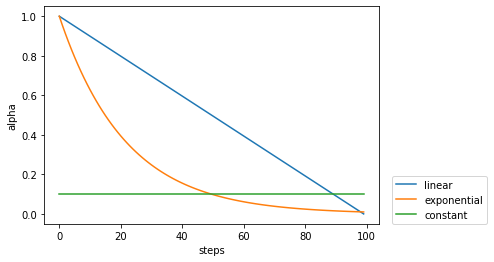

In [23]:
plt.plot(decayAlpha(1, 0, 100, "linear"), label='linear')
plt.plot(decayAlpha(1, 0.01, 100, "exponential"), label='exponential')
plt.plot(decayAlpha(0.1, 0.1, 100), label='constant')
plt.legend(loc=(1.04,0))
plt.xlabel('steps')
plt.ylabel('alpha')
plt.savefig('images/32.png', dpi=200, bbox_inches='tight')
plt.show()

In [20]:
def MonteCarloPrediction(env, policy, gamma, initial_alpha, final_alpha, maxSteps, noEpisodes, firstVisit, decayType=None, noStepsDecay=None):
    v = np.zeros(12) # including terminal states
    v_r = np.zeros((noEpisodes, 12))
    if not noStepsDecay:
        noStepsDecay = noEpisodes
    alphas = decayAlpha(initial_alpha, final_alpha, noStepsDecay, decayType)
    for episode in range(noEpisodes):
        if episode < noStepsDecay:
            alpha = alphas[episode]
        else:
            alpha = final_alpha
        t = generateTrajectory(env, policy, maxSteps)
        visited = np.zeros(12)
        for i, (currstate, a, r, newstate) in enumerate(t):
            if visited[currstate] and firstVisit:
                continue
            G = 0
            for j in range(i, len(t)):
                G += np.power(gamma, j-i) * t[j][2]
            v[currstate] += alpha * (G - v[currstate])
            visited[currstate] = 1
        v_r[episode] = v
    
    return v, v_r

In [24]:
v, v_r = MonteCarloPrediction(gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(1)), policy, 0.99, 0.1, 0.1, 10, 10, True)
print(v_r)

[[0.07549502 0.0851495  0.09005    0.         0.06603267 0.
  0.095      0.         0.06137235 0.         0.         0.        ]
 [0.15799552 0.17163455 0.181045   0.         0.14457891 0.
  0.095      0.         0.13553312 0.         0.         0.        ]
 [0.23224597 0.24947109 0.2629405  0.         0.21527052 0.
  0.095      0.         0.20227781 0.         0.         0.        ]
 [0.28931938 0.30967349 0.32669645 0.         0.26923849 0.
  0.095      0.         0.2527901  0.         0.         0.        ]
 [0.34553694 0.36875614 0.39402681 0.         0.32261265 0.
  0.095      0.         0.30300612 0.         0.         0.        ]
 [0.39613275 0.42193052 0.45462412 0.         0.37064939 0.
  0.095      0.         0.34820053 0.         0.         0.        ]
 [0.44166897 0.46978747 0.50916171 0.         0.41388245 0.
  0.095      0.         0.3888755  0.         0.         0.        ]
 [0.48265157 0.51285872 0.55824554 0.         0.45279221 0.
  0.095      0.         0.41602063 0.

In [45]:
v, v_r = MonteCarloPrediction(gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(1)), policy, 0.99, 0.1, 0.1, 10, 10, False)
print(v_r)

[[0.14824353 0.0851495  0.181045   0.         0.13016948 0.
  0.095      0.         0.06137235 0.         0.         0.        ]
 [0.22346917 0.17163455 0.2629405  0.         0.20230203 0.
  0.095      0.         0.13553312 0.         0.         0.        ]
 [0.29117226 0.24947109 0.33664645 0.         0.26722133 0.
  0.095      0.         0.20227781 0.         0.         0.        ]
 [0.34235304 0.30967349 0.50385576 0.         0.31599422 0.
  0.095      0.         0.2527901  0.         0.         0.        ]
 [0.39326723 0.42688052 0.55347019 0.         0.3646928  0.
  0.095      0.         0.30300612 0.         0.         0.        ]
 [0.43909001 0.52181822 0.59812317 0.         0.40852153 0.
  0.095      0.         0.34820053 0.         0.         0.        ]
 [0.48033051 0.59871776 0.63831085 0.         0.44796738 0.
  0.095      0.         0.3888755  0.         0.         0.        ]
 [0.51744696 0.66100639 0.67447977 0.         0.48346865 0.
  0.095      0.         0.44991359 0.

In [28]:
def TemporalDifferencePrediction(env, policy, gamma, initial_alpha, final_alpha, noEpisodes, decayType=None, noStepsDecay=None):
    v = np.zeros(12) # including terminal states
    v_r = np.zeros((noEpisodes, 12))
    if not noStepsDecay:
        noStepsDecay = noEpisodes
    alphas = decayAlpha(initial_alpha, final_alpha, noStepsDecay, decayType)
    for episode in range(noEpisodes):
        if episode < noStepsDecay:
            alpha = alphas[episode]
        else:
            alpha = final_alpha
        currstate = env.reset()
        done = False
        while not done:
            action = np.argmax(policy[currstate])
            newstate, r, done, _ = env.step(action)
            td_target = r + gamma * v[newstate] # the if not done condition is redundant since v[terminal state] is always 0
            td_error = td_target - v[currstate]
            v[currstate] += alpha * td_error
            currstate = newstate
            
        v_r[episode] = v
    
    return v, v_r

In [33]:
v, v_r = TemporalDifferencePrediction(gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(1)), policy, 0.99, 0.1, 0.1, 10)
print(v_r)

[[-0.0076     -0.004       0.0964      0.         -0.0076      0.
  -0.004396    0.         -0.004       0.          0.          0.        ]
 [-0.011236    0.0019436   0.18676     0.         -0.0115924   0.
  -0.004396    0.         -0.0083524   0.          0.          0.        ]
 [-0.01391998  0.01623848  0.268084    0.         -0.01554552  0.
  -0.004396    0.         -0.01266481  0.          0.          0.        ]
 [-0.01492038  0.03715495  0.33359689  0.         -0.01936905  0.
  -0.004396    0.         -0.01693733  0.          0.          0.        ]
 [-0.01375     0.05883211  0.4002372   0.         -0.02290926  0.
  -0.004396    0.         -0.02116114  0.          0.          0.        ]
 [-0.01055062  0.08491943  0.46021348  0.         -0.02597959  0.
  -0.004396    0.         -0.02531304  0.          0.          0.        ]
 [-0.00508853  0.11431219  0.51419213  0.         -0.02842614  0.
  -0.004396    0.         -0.02935371  0.          0.          0.        ]
 [ 0.00273723

In [30]:
def generateNStepTrajectory(env, policy, n):
    trajectory = []
    for step in range(n):
        currstate = env.state
        action = np.argmax(policy[currstate])
        newstate, r, done, _ = env.step(action)
        exp = (newstate, r, done)
        trajectory.append(exp)
        if done:
            break
    
    return trajectory

In [31]:
def calculateReturn(gamma, trajectory, n):
    G = 0
    for i, exp in enumerate(trajectory):
        newstate, r, done = exp
        G += pow(gamma, i) * r
    return G

In [32]:
def nStepTemporalDifferencePrediction(env, policy, gamma, initial_alpha, final_alpha, n, noEpisodes, decayType=None, noStepsDecay=None):
    v = np.zeros(12) # including terminal states
    v_r = np.zeros((noEpisodes, 12))
    if not noStepsDecay:
        noStepsDecay = noEpisodes
    alphas = decayAlpha(initial_alpha, final_alpha, noStepsDecay, decayType)
    for episode in range(noEpisodes):
        if episode < noStepsDecay:
            alpha = alphas[episode]
        else:
            alpha = final_alpha
        currstate = env.reset()
        done = False
        while not done:
            currstate = env.state
            trajectory = generateNStepTrajectory(env, policy, n)
            g_partial = calculateReturn(gamma, trajectory, n)
            newstate, r, done = trajectory[-1]
            td_target = g_partial + pow(gamma, len(trajectory)) * v[newstate]
            td_error = td_target - v[currstate]
            v[currstate] += alpha * td_error
            
        v_r[episode] = v
    
    return v, v_r

In [37]:
v, v_r = nStepTemporalDifferencePrediction(gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(1)), policy, 0.99, 0.1, 0.1, 1, 10)
print(v_r)

[[-0.0076     -0.004       0.0964      0.         -0.0076      0.
  -0.004396    0.         -0.004       0.          0.          0.        ]
 [-0.011236    0.0019436   0.18676     0.         -0.0115924   0.
  -0.004396    0.         -0.0083524   0.          0.          0.        ]
 [-0.01391998  0.01623848  0.268084    0.         -0.01554552  0.
  -0.004396    0.         -0.01266481  0.          0.          0.        ]
 [-0.01492038  0.03715495  0.33359689  0.         -0.01936905  0.
  -0.004396    0.         -0.01693733  0.          0.          0.        ]
 [-0.01375     0.05883211  0.4002372   0.         -0.02290926  0.
  -0.004396    0.         -0.02116114  0.          0.          0.        ]
 [-0.01055062  0.08491943  0.46021348  0.         -0.02597959  0.
  -0.004396    0.         -0.02531304  0.          0.          0.        ]
 [-0.00508853  0.11431219  0.51419213  0.         -0.02842614  0.
  -0.004396    0.         -0.02935371  0.          0.          0.        ]
 [ 0.00273723

In [42]:
v, v_r = nStepTemporalDifferencePrediction(gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(1)), policy, 0.99, 0.1, 0.1, 20, 10)
print(v_r)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.06137235 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.13553312 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.20227781 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.2527901  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.30300612 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.34820053 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.3888755  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.41602063 0.

In [43]:
def TDLambdaPrediction(env, policy, gamma, initial_alpha, final_alpha, lambda_, noEpisodes, decayType=None, noStepsDecay=None):
    v = np.zeros(12) # including terminal states
    v_r = np.zeros((noEpisodes, 12))
    E = np.zeros(12)
    if not noStepsDecay:
        noStepsDecay = noEpisodes
    alphas = decayAlpha(initial_alpha, final_alpha, noStepsDecay, decayType)
    for episode in range(noEpisodes):
        if episode < noStepsDecay:
            alpha = alphas[episode]
        else:
            alpha = final_alpha
        currstate = env.reset()
        done = False
        while not done:
            action = np.argmax(policy[currstate])
            newstate, r, done, _ = env.step(action)
            td_target = r + gamma * v[newstate] # the if not done condition is redundant since v[terminal state] is always 0
            td_error = td_target - v[currstate]
            E[currstate] += 1
            v[currstate] += alpha * td_error * E[currstate]
            E = gamma * lambda_ * E
            currstate = newstate
            
        v_r[episode] = v
    
    return v, v_r

In [44]:
v, v_r = TDLambdaPrediction(gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(1)), policy, 0.99, 0.1, 0.1, 1, 10)
print(v_r)

[[-0.011164   -0.004       0.19480204  0.         -0.011164    0.
  -0.004396    0.         -0.004       0.          0.          0.        ]
 [-0.02052664  0.02630522  0.42694507  0.         -0.02247738  0.
  -0.004396    0.         -0.01300355  0.          0.          0.        ]
 [-0.01808639  0.12742087  0.6413683   0.         -0.03646928  0.
  -0.004396    0.         -0.02689048  0.          0.          0.        ]
 [ 0.02916067  0.30032959  0.85644355  0.         -0.04615001  0.
  -0.004396    0.         -0.04500886  0.          0.          0.        ]
 [ 0.14837476  0.56574633  0.95807808  0.         -0.02790767  0.
  -0.004396    0.         -0.06303578  0.          0.          0.        ]
 [ 0.36839728  0.80009915  0.99021314  0.          0.05168304  0.
  -0.004396    0.         -0.06541124  0.          0.          0.        ]
 [ 0.62059413  0.9164148   0.99825488  0.          0.23076052  0.
  -0.004396    0.         -0.02046458  0.          0.          0.        ]
 [ 0.79485614

In [47]:
v, v_r = TDLambdaPrediction(gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(1)), policy, 0.99, 0.1, 0.1, 0, 10)
print(v_r)

[[-0.0076     -0.004       0.0964      0.         -0.0076      0.
  -0.004396    0.         -0.004       0.          0.          0.        ]
 [-0.011236    0.0019436   0.18676     0.         -0.0115924   0.
  -0.004396    0.         -0.0083524   0.          0.          0.        ]
 [-0.01391998  0.01623848  0.268084    0.         -0.01554552  0.
  -0.004396    0.         -0.01266481  0.          0.          0.        ]
 [-0.01492038  0.03715495  0.33359689  0.         -0.01936905  0.
  -0.004396    0.         -0.01693733  0.          0.          0.        ]
 [-0.01375     0.05883211  0.4002372   0.         -0.02290926  0.
  -0.004396    0.         -0.02116114  0.          0.          0.        ]
 [-0.01055062  0.08491943  0.46021348  0.         -0.02597959  0.
  -0.004396    0.         -0.02531304  0.          0.          0.        ]
 [-0.00508853  0.11431219  0.51419213  0.         -0.02842614  0.
  -0.004396    0.         -0.02935371  0.          0.          0.        ]
 [ 0.00273723

In [52]:
v, v_r = TDLambdaPrediction(gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(1)), policy, 0.99, 0.1, 0.1, 0.5, 10)
print(v_r)

[[-0.009382   -0.004       0.12100051  0.         -0.009382    0.
  -0.004396    0.         -0.004       0.          0.          0.        ]
 [-0.01287744  0.00444006  0.21215277  0.         -0.01339412  0.
  -0.004396    0.         -0.0085369   0.          0.          0.        ]
 [-0.01521841  0.02149488  0.29336549  0.         -0.01744716  0.
  -0.004396    0.         -0.01314237  0.          0.          0.        ]
 [-0.01557929  0.0450893   0.40785532  0.         -0.02132421  0.
  -0.004396    0.         -0.01769046  0.          0.          0.        ]
 [-0.01354235  0.08938681  0.46859203  0.         -0.02475973  0.
  -0.004396    0.         -0.02206509  0.          0.          0.        ]
 [-0.00724688  0.13651145  0.52253466  0.         -0.0276669   0.
  -0.004396    0.         -0.02637271  0.          0.          0.        ]
 [ 0.0031453   0.18455421  0.57099417  0.         -0.02964678  0.
  -0.004396    0.         -0.0305357   0.          0.          0.        ]
 [ 0.0171527 

In [ ]:
def trueValue(env, policy):
    v = np.zeros(12)
    

In [86]:
v_r = np.zeros((100, 500, 12))
for i in range(100):
    _, v_r[i] = MonteCarloPrediction(
        gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(i+1)), 
        policy, 0.99, 0.5, 0.01, 20, 500, True, decayType='exponential', noStepsDecay=250
        )

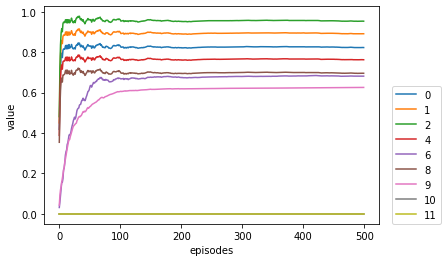

In [87]:
v_r = np.mean(v_r, axis=0)
for i in non_terminal:
    plt.plot(np.arange(500), v_r[:, i], label=i)
plt.legend(loc=(1.04,0))
plt.xlabel('episodes')
plt.ylabel('value')
plt.savefig('images/381.png', dpi=200, bbox_inches='tight')
plt.show()

In [62]:
v_r = np.zeros((100, 500, 12))
for i in range(100):
    _, v_r[i] = MonteCarloPrediction(
        gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(i+1)), 
        policy, 0.99, 0.05, 0.05, 20, 500, True
        )

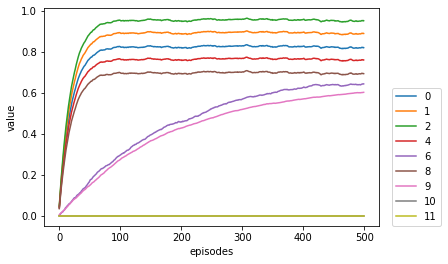

In [63]:
v_r = np.mean(v_r, axis=0)
for i in non_terminal:
    plt.plot(np.arange(500), v_r[:, i], label=i)
plt.legend(loc=(1.04,0))
plt.xlabel('episodes')
plt.ylabel('value')
plt.savefig('images/382.png', dpi=200, bbox_inches='tight')
plt.show()

In [64]:
v_r = np.zeros((100, 500, 12))
for i in range(100):
    _, v_r[i] = MonteCarloPrediction(
        gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(i+1)), 
        policy, 0.99, 0.5, 0.01, 20, 500, False, decayType='exponential', noStepsDecay=250
        )

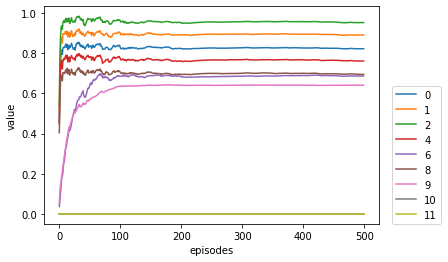

In [65]:
v_r = np.mean(v_r, axis=0)
for i in non_terminal:
    plt.plot(np.arange(500), v_r[:, i], label=i)
plt.legend(loc=(1.04,0))
plt.xlabel('episodes')
plt.ylabel('value')
plt.savefig('images/391.png', dpi=200, bbox_inches='tight')
plt.show()

In [66]:
v_r = np.zeros((100, 500, 12))
for i in range(100):
    _, v_r[i] = MonteCarloPrediction(
        gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(i+1)), 
        policy, 0.99, 0.05, 0.05, 20, 500, False
        )

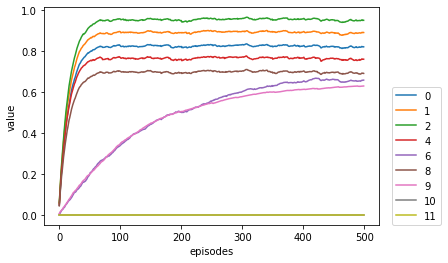

In [67]:
v_r = np.mean(v_r, axis=0)
for i in non_terminal:
    plt.plot(np.arange(500), v_r[:, i], label=i)
plt.legend(loc=(1.04,0))
plt.xlabel('episodes')
plt.ylabel('value')
plt.savefig('images/392.png', dpi=200, bbox_inches='tight')
plt.show()

In [68]:
v_r = np.zeros((100, 500, 12))
for i in range(100):
    _, v_r[i] = TemporalDifferencePrediction(
        gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(i+1)), 
        policy, 0.99, 0.5, 0.01, 500, decayType='exponential', noStepsDecay=250
        )

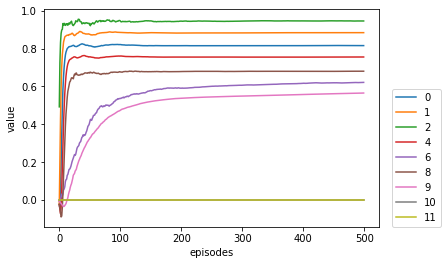

In [69]:
v_r = np.mean(v_r, axis=0)
for i in non_terminal:
    plt.plot(np.arange(500), v_r[:, i], label=i)
plt.legend(loc=(1.04,0))
plt.xlabel('episodes')
plt.ylabel('value')
plt.savefig('images/3101.png', dpi=200, bbox_inches='tight')
plt.show()

In [70]:
v_r = np.zeros((100, 500, 12))
for i in range(100):
    _, v_r[i] = nStepTemporalDifferencePrediction(
        gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(i+1)), 
        policy, 0.99, 0.5, 0.01, 3, 500, decayType='exponential', noStepsDecay=250
        )

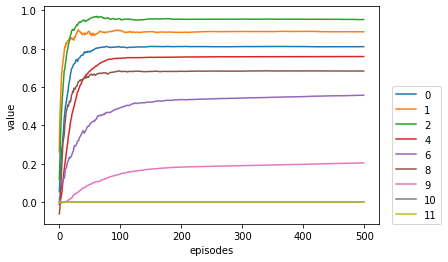

In [71]:
v_r = np.mean(v_r, axis=0)
for i in non_terminal:
    plt.plot(np.arange(500), v_r[:, i], label=i)
plt.legend(loc=(1.04,0))
plt.xlabel('episodes')
plt.ylabel('value')
plt.savefig('images/311.png', dpi=200, bbox_inches='tight')
plt.show()

In [72]:
v_r = np.zeros((100, 500, 12))
for i in range(100):
    _, v_r[i] = TDLambdaPrediction(
        gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(i+1)), 
        policy, 0.99, 0.5, 0.01, 0.3, 500, decayType='exponential', noStepsDecay=250
        )

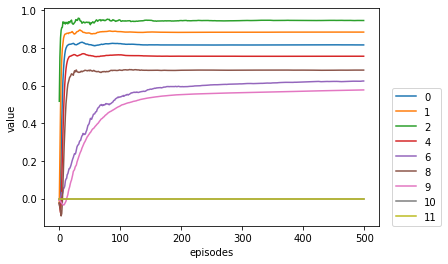

In [73]:
v_r = np.mean(v_r, axis=0)
for i in non_terminal:
    plt.plot(np.arange(500), v_r[:, i], label=i)
plt.legend(loc=(1.04,0))
plt.xlabel('episodes')
plt.ylabel('value')
plt.savefig('images/312.png', dpi=200, bbox_inches='tight')
plt.show()

In [79]:
def TDLambdaPredictionETrace(env, policy, gamma, initial_alpha, final_alpha, lambda_, noEpisodes, decayType=None, noStepsDecay=None):
    v = np.zeros(12) # including terminal states
    v_r = np.zeros((noEpisodes, 12))
    E = np.zeros(12)
    if not noStepsDecay:
        noStepsDecay = noEpisodes
    alphas = decayAlpha(initial_alpha, final_alpha, noStepsDecay, decayType)
    etrace = []
    for episode in range(noEpisodes):
        if episode < noStepsDecay:
            alpha = alphas[episode]
        else:
            alpha = final_alpha
        currstate = env.reset()
        done = False
        while not done:
            if episode == 100:
                etrace.append(E)
            action = np.argmax(policy[currstate])
            newstate, r, done, _ = env.step(action)
            td_target = r + gamma * v[newstate] # the if not done condition is redundant since v[terminal state] is always 0
            td_error = td_target - v[currstate]
            E[currstate] += 1
            v[currstate] += alpha * td_error * E[currstate]
            E = gamma * lambda_ * E
            currstate = newstate
        etrace.append(E)
            
        v_r[episode] = v
    
    return v, v_r, etrace

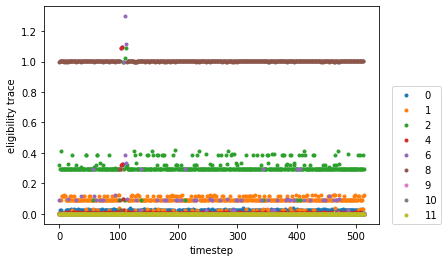

In [82]:
_, v_r, etrace = TDLambdaPredictionETrace(
    gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(1)), 
    policy, 0.99, 0.5, 0.01, 0.3, 500, decayType='exponential', noStepsDecay=250
    )
etrace = np.array(etrace)
for i in non_terminal:
    plt.scatter(np.arange(len(etrace)), etrace[:, i], marker='.', label=i)
plt.legend(loc=(1.04,0))
plt.xlabel('timestep')
plt.ylabel('eligibility trace')
plt.savefig('images/313.png', dpi=200, bbox_inches='tight')
plt.show()

In [88]:
v_r = np.zeros((100, 500, 12))
for i in range(100):
    _, v_r[i] = MonteCarloPrediction(
        gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(i+1)), 
        policy, 0.99, 0.5, 0.01, 20, 500, True, decayType='exponential', noStepsDecay=250
        )

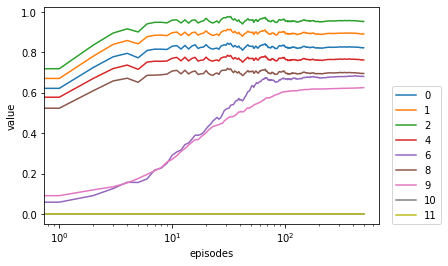

In [89]:
v_r = np.mean(v_r, axis=0)
plt.xscale("log")
for i in non_terminal:
    plt.plot(np.arange(500), v_r[:, i], label=i)
plt.legend(loc=(1.04,0))
plt.xlabel('episodes')
plt.ylabel('value')
plt.savefig('images/314.png', dpi=200, bbox_inches='tight')
plt.show()

In [90]:
v_r = np.zeros((100, 500, 12))
for i in range(100):
    _, v_r[i] = MonteCarloPrediction(
        gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(i+1)), 
        policy, 0.99, 0.5, 0.01, 20, 500, False, decayType='exponential', noStepsDecay=250
        )

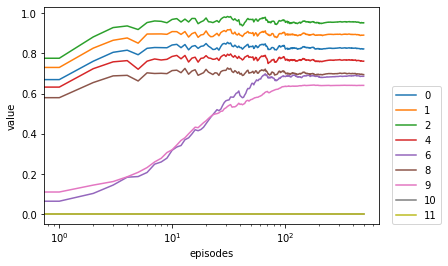

In [91]:
v_r = np.mean(v_r, axis=0)
plt.xscale("log")
for i in non_terminal:
    plt.plot(np.arange(500), v_r[:, i], label=i)
plt.legend(loc=(1.04,0))
plt.xlabel('episodes')
plt.ylabel('value')
plt.savefig('images/315.png', dpi=200, bbox_inches='tight')
plt.show()

In [92]:
v_r = np.zeros((100, 500, 12))
for i in range(100):
    _, v_r[i] = TemporalDifferencePrediction(
        gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(i+1)), 
        policy, 0.99, 0.5, 0.01, 500, decayType='exponential', noStepsDecay=250
        )

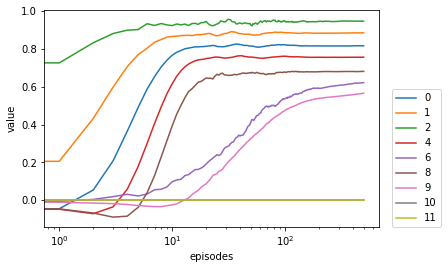

In [93]:
v_r = np.mean(v_r, axis=0)
plt.xscale("log")
for i in non_terminal:
    plt.plot(np.arange(500), v_r[:, i], label=i)
plt.legend(loc=(1.04,0))
plt.xlabel('episodes')
plt.ylabel('value')
plt.savefig('images/316.png', dpi=200, bbox_inches='tight')
plt.show()

In [94]:
v_r = np.zeros((100, 500, 12))
for i in range(100):
    _, v_r[i] = nStepTemporalDifferencePrediction(
        gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(i+1)), 
        policy, 0.99, 0.5, 0.01, 3, 500, decayType='exponential', noStepsDecay=250
        )

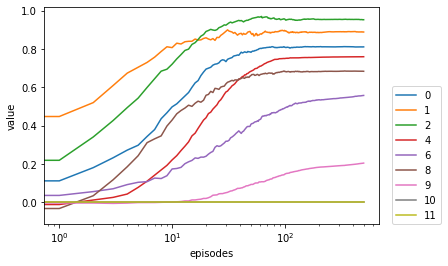

In [95]:
v_r = np.mean(v_r, axis=0)
plt.xscale("log")
for i in non_terminal:
    plt.plot(np.arange(500), v_r[:, i], label=i)
plt.legend(loc=(1.04,0))
plt.xlabel('episodes')
plt.ylabel('value')
plt.savefig('images/317.png', dpi=200, bbox_inches='tight')
plt.show()

In [96]:
v_r = np.zeros((100, 500, 12))
for i in range(100):
    _, v_r[i] = TDLambdaPrediction(
        gym.make('gym:random-maze-env-v0', rng=np.random.default_rng(i+1)), 
        policy, 0.99, 0.5, 0.01, 0.3, 500, decayType='exponential', noStepsDecay=250
        )

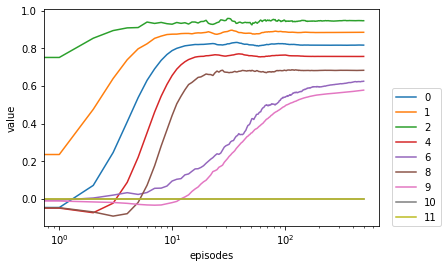

In [97]:
v_r = np.mean(v_r, axis=0)
plt.xscale("log")
for i in non_terminal:
    plt.plot(np.arange(500), v_r[:, i], label=i)
plt.legend(loc=(1.04,0))
plt.xlabel('episodes')
plt.ylabel('value')
plt.savefig('images/318.png', dpi=200, bbox_inches='tight')
plt.show()